### 代码实现

项目链接：[猫狗大战](https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/overview)

In [1]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
from torchinfo import summary

import os
import sys
from PIL import Image # pip install Pillow

### 数据加载

In [2]:
%ls ../data/dogs-vs-cats/

sample_submission.csv  test/  train/


In [3]:
# 原始数据路径
data_path = "../data/dogs-vs-cats/"

# 指定训练数据集的路径并获取该路径下所有文件的文件名列表
train_folder = data_path + 'train/'
train_filelist = os.listdir(train_folder)

# 输出训练数据集的文件数量和前20个文件名
print("train: {0} {1} \n".format(len(train_filelist), train_filelist[:20]))

# 指定测试数据集的路径并获取该路径下所有文件的文件名列表
test_folder = data_path + 'test/'
test_filelist = os.listdir(test_folder)

# 输出测试数据集的文件数量和前20个文件名
print("test: {0} {1} \n".format(len(test_filelist), test_filelist[:20]))

train: 25000 ['cat.10859.jpg', 'dog.1175.jpg', 'cat.6903.jpg', 'cat.9857.jpg', 'dog.6882.jpg', 'cat.91.jpg', 'dog.7006.jpg', 'dog.6140.jpg', 'cat.309.jpg', 'dog.10759.jpg', 'cat.2508.jpg', 'dog.7643.jpg', 'dog.1588.jpg', 'cat.4146.jpg', 'cat.10983.jpg', 'dog.6874.jpg', 'cat.9508.jpg', 'cat.2756.jpg', 'cat.8387.jpg', 'cat.4913.jpg'] 

test: 12500 ['12344.jpg', '8543.jpg', '3743.jpg', '7480.jpg', '7931.jpg', '7563.jpg', '6163.jpg', '1002.jpg', '11783.jpg', '6892.jpg', '9586.jpg', '3950.jpg', '5053.jpg', '138.jpg', '1609.jpg', '2043.jpg', '10193.jpg', '5882.jpg', '703.jpg', '5453.jpg'] 



In [4]:
# 自定义数据集
class DogsVSCats(Dataset):
    def __init__(self, data_dir, split="train", transform=None):
        # 拼接数据集中所有图片路径并计算总数
        imgs = [os.path.join(data_dir, img) for img in os.listdir(data_dir)]
        imgs_num = len(imgs)
        
        # 根据数据集划分（train/val/test），选择不同数据
        # 训练集：验证集设为8:2
        if split == 'train':
            self.image_paths = imgs[:int(0.8 * imgs_num)]
        elif split == 'val':
            self.image_paths = imgs[int(0.8 * imgs_num):]
        else:
            self.image_paths = imgs
        self.split = split
        
        # 根据数据集划分（train/val/test）定义默认数据转换方法
        if transform is None:
            if split == 'train':
                self.transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(), # 随机水平翻转
                    transforms.RandomRotation(10), # 随机旋转
                    transforms.Resize((256, 256)), # 调整图像大小
                    transforms.RandomCrop(224), # 从随机位置裁剪指定大小
                    transforms.ToTensor(), # 将数据转换为张量
                    # 对三通道数据进行归一化(均值，标准差)
                    # 数值是从ImageNet数据集上的百万张图片中随机抽样计算得到
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])
            else:
                self.transform = transforms.Compose([
                    transforms.Resize((224, 224)), # 调整图像大小
                    transforms.ToTensor(), # 将数据转换为张量
                    # 对三通道数据进行归一化(均值，标准差)
                    # 数值是从ImageNet数据集上的百万张图片中随机抽样计算得到
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])
        else:
            self.transform = transform
            
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # 加载图像数据并对图像数据进行转换
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = self.transform(image)
        
        # 从图片路径中提取标签信息并转换为张量数据
        filename = self.image_paths[idx].split("/")[-1]
        if self.split == 'test':
            label = int(filename.split('.')[0])
        else:
            label = 1 if 'dog' in filename else 0
        label = torch.tensor(label, dtype=torch.long)
        
        return image, label

In [5]:
# 验证数据集是否可用
dataset = DogsVSCats(
    '../data/dogs-vs-cats/train/', 
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
)

In [6]:
# 定义绘图函数，传入dataset即可
def plot(dataset, shuffle=False, cmap=None):
    # 创建数据加载器
    dataloader = DataLoader(dataset, batch_size=16, shuffle=shuffle)
    
    # 取出一组数据
    images, labels = next(iter(dataloader))
    
    # 将通道维度(C)移到最后一个维度，方便使用matplotlib绘图
    images = np.transpose(images, (0, 2, 3, 1))  

    # 创建2x2的子图对象
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

    # 遍历每个子图，绘制图像并添加子图标题
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap=cmap)
        ax.axis('off') # 隐藏坐标轴

        if hasattr(dataset, 'classes'): # 如果数据集有预定义的类别名称，使用该名称作为子图标题
            ax.set_title(dataset.classes[labels[i]], fontsize=12)
        else: # 否则使用类别索引作为子图标题
            ax.set_title(labels[i], fontsize=12)

    plt.show()

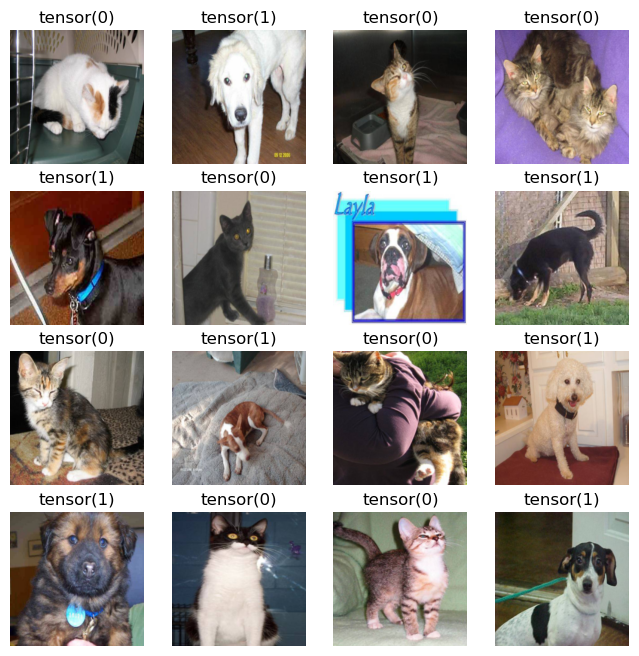

In [7]:
plot(dataset)

In [8]:
# 依次定义训练集、验证集、测试集
train_dataset = DogsVSCats('../data/dogs-vs-cats/train/', split = 'train')
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

val_dataset = DogsVSCats('../data/dogs-vs-cats/train/', split = 'val')
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

test_dataset = DogsVSCats('../data/dogs-vs-cats/test/', split = 'test')
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [9]:
# 查看数据集样本数量
len(train_dataset), len(val_dataset), len(test_dataset)

(20000, 5000, 12500)

### 模型训练

In [10]:
class Trainer:
    def __init__(self, model, train_loader, val_loader):
        # 初始化训练数据集和验证数据集的dataloader
        self.train_loader = train_loader
        self.val_loader = val_loader
        
        # 判断可用的设备是 CPU 还是 GPU，并将模型移动到对应的计算资源设备上
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        
        # 定义优化器、损失函数和学习率调度器
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.001)
        self.criterion = nn.CrossEntropyLoss()
        self.scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.95)
        
        # 记录训练过程中的损失和验证过程中的准确率
        self.train_losses = []
        self.val_accuracy = []
    
    def train(self, num_epochs):
        # tqdm用于显示进度条并评估任务时间开销
        for epoch in tqdm(range(num_epochs), file=sys.stdout):
            # 记录损失值
            total_loss = 0

            # 批量训练
            self.model.train()
            for images, labels in self.train_loader:
                # 将数据转移到指定计算资源设备上
                images = images.to(self.device)
                labels = labels.to(self.device)

                # 预测、损失函数、反向传播
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                # 记录训练集loss
                total_loss += loss.item()
            
            # 更新优化器的学习率
            self.scheduler.step()
            # 计算验证集的准确率
            accuracy = self.validate()
            
            # 记录训练集损失和验证集准确率
            self.train_losses.append(np.log10(total_loss)) # 由于数值有时较大，这里取对数
            self.val_accuracy.append(accuracy)
            
            # 打印中间值
            if epoch % 5 == 0:
                tqdm.write("Epoch: {0} Loss: {1} Acc: {2}".format(
                    epoch, self.train_losses[-1], self.val_accuracy[-1]))
    
    def validate(self):
        # 测试模型，不计算梯度
        self.model.eval()
        
        # 记录总数和预测正确数
        total = 0
        correct = 0
        
        with torch.no_grad():
            for images, labels in self.val_loader:
                # 将数据转移到指定计算资源设备上
                images = images.to(self.device)
                labels = labels.to(self.device)

                # 预测
                outputs = self.model(images)
                # 记录验证集总数和预测正确数
                total += labels.size(0)
                correct += (outputs.argmax(1) == labels).sum().item()
        
        # 返回准确率
        accuracy = correct / total
        return accuracy

In [11]:
# 定义 ResNet50 模型
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
# 获取全连接层的输入特征数
num_features = model.fc.in_features
# 将全连接层替换成一个新的全连接层
model.fc = nn.Linear(in_features=num_features, out_features=2, bias=True)

In [12]:
# 创建一个 Trainer 类的实例
trainer = Trainer(model, train_loader, val_loader)
# 训练模型，迭代 20 个周期
trainer.train(num_epochs = 20)

Epoch: 0 Loss: 1.8703523967529723 Acc: 0.9776
Epoch: 5 Loss: 1.0845601669125573 Acc: 0.9882  
Epoch: 10 Loss: 0.9256808238968409 Acc: 0.989   
Epoch: 15 Loss: 0.8714442646792343 Acc: 0.9902  
100%|██████████| 20/20 [41:37<00:00, 124.89s/it]


In [13]:
# 最终准确率
trainer.val_accuracy[-1]

0.9906

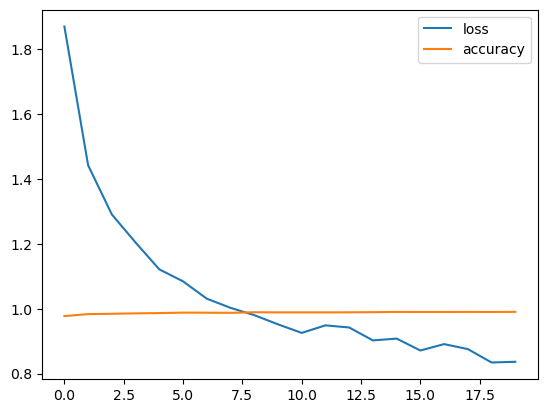

In [14]:
# 使用Matplotlib绘制损失和准确率的曲线图
plt.plot(trainer.train_losses, label='loss')
plt.plot(trainer.val_accuracy, label='accuracy')
plt.legend()
plt.show()

### 模型预测

In [15]:
def inference(trainer, test_loader):
    # 设置模型为评估模式
    trainer.model.eval()
    
    # 记录测试样本的id和模型预测结果
    ids = []
    predictions = []

    with torch.no_grad():
        # 遍历测试集，这里的labels其实是id
        for images, labels in test_loader:
            # 将数据转移到指定计算资源设备上
            images = images.to(trainer.device)
            # 对图片进行预测
            outputs = trainer.model(images)
            # 获取预测结果，下划线表示忽略torch.max函数返回值中的最大值项
            _, predicted = torch.max(outputs.data, 1)
            # 将测试样本的 ID 添加到列表中
            ids.extend(labels.numpy().tolist())
            # 将预测结果添加到列表中
            predictions.extend(predicted.cpu().numpy().tolist())

    return ids, predictions

In [16]:
# 对测试集进行预测，获得预测结果
ids, predictions = inference(trainer, test_loader)

# 输出前 20 个样本的预测结果
predictions[:20]

[0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0]

In [17]:
# 在分类正确的情况下，0.995和1.0的评估差异不大
print(F.binary_cross_entropy(torch.tensor([1.0]), torch.tensor([1.0])))
print(F.binary_cross_entropy(torch.tensor([0.995]), torch.tensor([1.0])))

tensor(0.)
tensor(0.0050)


In [18]:
# 但在分类错误的情况下，其评估差异就差了十几倍
print(F.binary_cross_entropy(torch.tensor([1.0]), torch.tensor([0.0])))
print(F.binary_cross_entropy(torch.tensor([0.995]), torch.tensor([0.0])))

tensor(100.)
tensor(5.2983)


In [19]:
import pandas as pd

# 将测试样本的id和预测结果保存到一个Pandas的DataFrame中
# 并将预测结果限制在[0.005, 0.995]之间
results = pd.DataFrame({'id': ids, 'label': np.clip(predictions, 0.005, 0.995)})
# 按照测试样本的 ID 进行排序
results = results.sort_values(by='id').reset_index(drop=True)
# 打印结果
results

,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
...,...,...
12495,12496,0.005
12496,12497,0.005
12497,12498,0.995
12498,12499,0.995


In [20]:
# 保存csv文件
results.to_csv("./submission.csv", index=False)